In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.4.1 cuda: True


In [2]:
## Load dataset
data_path = "../../../Rings_2D"
OB = torch.from_numpy(np.load(data_path + '/ob.npy')).float()
STATE = torch.from_numpy(np.load(data_path + '/state.npy')).float()
MU = torch.from_numpy(np.load(data_path + '/mu.npy')).float()
ANGLE = torch.from_numpy(np.load(data_path + '/angle.npy')).float()

NUM_DATASETS, N, D = OB.shape

SAMPLE_SIZE = 10
BATCH_SIZE = 20
NUM_BATCHES = int((NUM_DATASETS / BATCH_SIZE))
NUM_EPOCHS = 500
NUM_HIDDEN = 32
LEARNING_RATE = 1e-3
# CUDA = torch.cuda.is_available()
CUDA = False
DEVICE = torch.device('cuda:0')

RADI = torch.ones(1) * 2.0
NOISE_SIGMA = torch.ones(1) * 0.1
lg2pi = torch.ones(1) * 2 * math.pi
if CUDA:
    RADI = RADI.cuda().to(DEVICE)
    NOISE_SIGMA = NOISE_SIGMA.cuda().to(DEVICE)
    lg2pi = lg2pi.cuda().to(DEVICE)
    
PATH = 'ag-phase3-reparam-run2'

In [3]:
from local_enc_angle_reparam import *
from decoder import *
# initialization
enc_angle = Enc_angle(D, NUM_HIDDEN, CUDA, DEVICE)
dec_x = Dec_x(2, NUM_HIDDEN, CUDA)

if CUDA:
    enc_angle.cuda().to(DEVICE)
    dec_x.cuda().to(DEVICE)
optimizer =  torch.optim.Adam(list(enc_angle.parameters())+list(dec_x.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

In [5]:
enc_angle.load_state_dict(torch.load('../results/enc-angle-' + PATH))
dec_x.load_state_dict(torch.load('../results/dec-x-' + PATH))

In [6]:
# for epoch in range(NUM_EPOCHS):
#     time_start = time.time()
#     LOSS_phi = 0.0
#     LOSS_theta = 0.0
#     ELBO = 0.0
#     EUBO = 0.0
#     ESS = 0.0
#     indices = torch.randperm(NUM_DATASETS)
#     for step in range(NUM_BATCHES):
#         optimizer.zero_grad()
#         batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
#         ob = OB[batch_indices]
#         state = STATE[batch_indices]
#         mu = MU[batch_indices]
#         mu = mu.repeat(SAMPLE_SIZE, 1, 1, 1)
#         shuffled = shuffler(torch.cat((ob, state), -1)).repeat(SAMPLE_SIZE, 1, 1, 1)
        
#         if CUDA:
#             shuffled = shuffled.cuda().to(DEVICE)
#             mu = mu.cuda().to(DEVICE)
#         ob = shuffled[:, :, :, :2]
#         state = shuffled[:, :, :, 2:]
#         q, p = enc_angle(ob, state, mu)
#         angle = p['angles'].value * 2 * math.pi
#         p_recon = dec_x(ob, state, mu, angle, NOISE_SIGMA)
#         ll = p_recon['likelihood'].log_prob.sum(-1)
#         log_w = p['angles'].log_prob.sum(-1) - q['angles'].log_prob.sum(-1) + ll
#         w = torch.softmax(log_w, 0).detach()
# #         loss_phi = (w * (- q['angles'].log_prob.sum(-1))).sum(0).sum(-1).mean()
# #         loss_theta = (w * (- ll)).sum(0).sum(-1).mean()
#         elbo = log_w.sum(-1).mean()
#         eubo = (w * log_w).sum(0).sum(-1).mean()
#         ess = (1 / (w ** 2).sum(0)).mean()
#         loss = - elbo
#         loss.backward()
#         optimizer.step()
#         ELBO += elbo
#         EUBO += eubo
#         ESS += ess
#     time_end = time.time()
#     flog = open('../results/log-' + PATH + '.txt', 'a+')
#     print('epoch=%d, eubo=%.4f, elbo=%.4f, ess=%.4f' % (epoch,  EUBO / NUM_BATCHES, ELBO / NUM_BATCHES, ESS / NUM_BATCHES), file=flog)
#     flog.close()
#     print('epoch=%d, eubo=%.4f, elbo=%.4f, ess=%.4f (%ds)' % (epoch,  EUBO / NUM_BATCHES, ELBO / NUM_BATCHES, ESS / NUM_BATCHES, time_end - time_start))

In [5]:
# torch.save(enc_angle.state_dict(), '../results/enc-angle-' + PATH)
# torch.save(dec_x.state_dict(), '../results/dec-x-' + PATH)

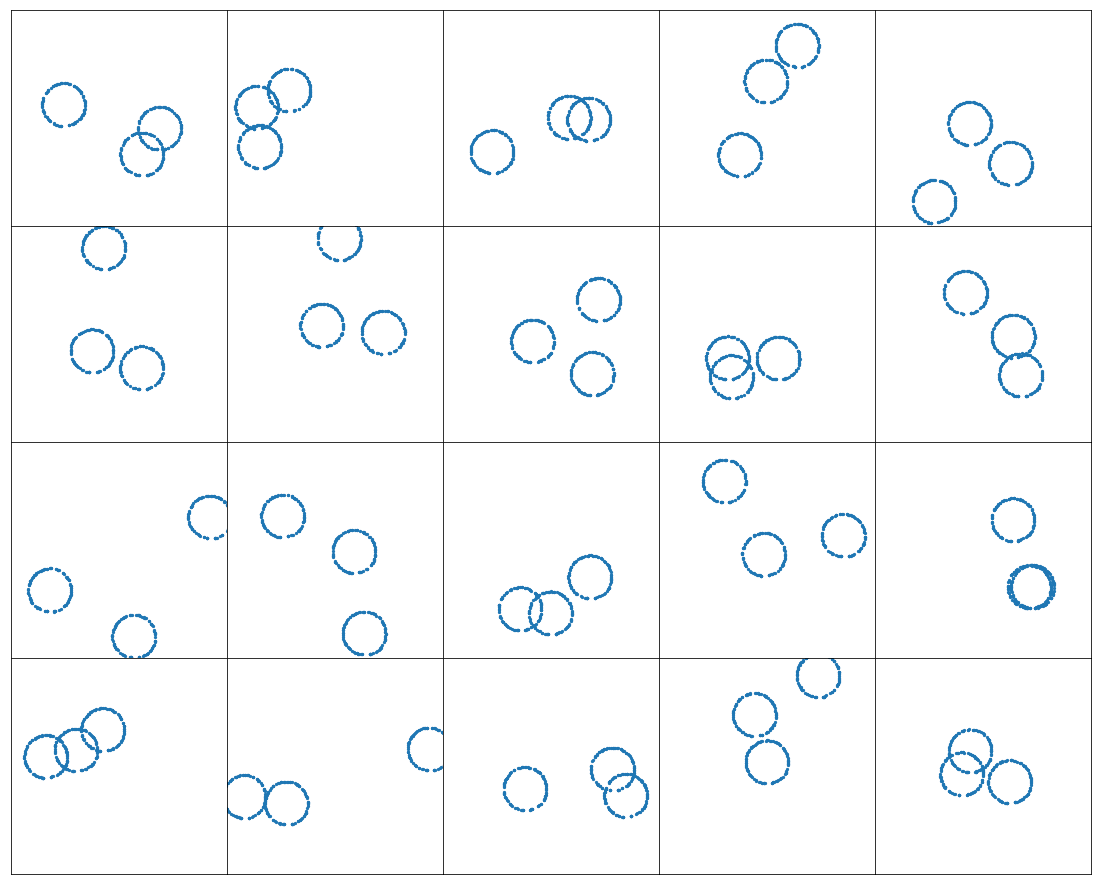

In [8]:
indices = torch.randperm(NUM_DATASETS)
batch_indices = indices[0*BATCH_SIZE : (0+1)*BATCH_SIZE]
ob = OB[batch_indices]
state = STATE[batch_indices]
angle_true = ANGLE[batch_indices]

mu = MU[batch_indices]
mu = mu.repeat(SAMPLE_SIZE, 1, 1, 1)
shuffled = shuffler(torch.cat((ob, state, angle_true), -1)).repeat(SAMPLE_SIZE, 1, 1, 1)
if CUDA:
    shuffled = shuffled.cuda().to(DEVICE)
    mu = mu.cuda().to(DEVICE)
ob = shuffled[:, :, :, :2]
state = shuffled[:, :, :, 2:-1]
angle_true = shuffled[:,:,:,-1].unsqueeze(-1)
q, p = enc_angle(ob, state, mu)
angle = q['angles'].value * 2 * math.pi
p_recon = dec_x(ob, state, mu, angle, NOISE_SIGMA)
recon_mu = p_recon['likelihood'].dist.loc.cpu().data.numpy()
plot_recon(recon_mu, PATH, 15, 10)

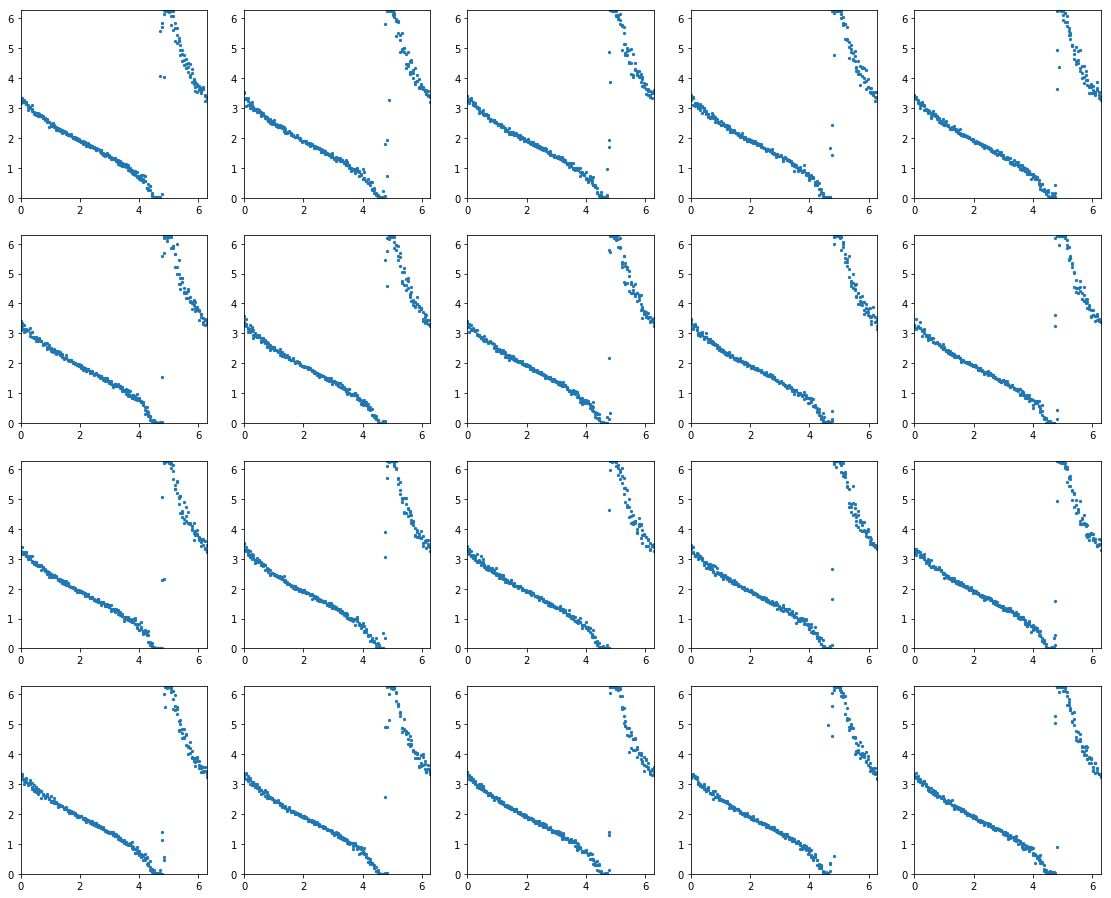

In [16]:
plot_angles(angle, angle_true, 15)

In [ ]:
plt.plot(samples.data.numpy(), log_pdf.exp().data.numpy())

In [ ]:
samples.shape